In [2]:
import pandas as pd, re, io
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

try:
    from google.colab import files
    up = files.upload()
    fname = list(up.keys())[0]
except:
    fname = "IMDB Reviews.xlsx"

def read_any(fname):
    if 'up' in globals():
        raw = io.BytesIO(up[fname])
        try:
            return pd.read_excel(raw)
        except:
            raw.seek(0)
            try:
                return pd.read_csv(raw, encoding="utf-8")
            except:
                raw.seek(0)
                return pd.read_csv(raw, encoding="latin1")
    else:
        try:
            return pd.read_excel(fname)
        except:
            try:
                return pd.read_csv(fname, encoding="utf-8")
            except:
                return pd.read_csv(fname, encoding="latin1")

df = read_any(fname)
df.columns = [c.strip() for c in df.columns]

tcands = ["review","Review","text","Texto","Comentario"]
lcands = ["sentimento","Sentiment","Sentimiento","sentiment","label","Label"]
text_col = next(x for x in tcands if x in df.columns)
label_col = next(x for x in lcands if x in df.columns)

def normalize_label(v):
    s = str(v).lower().strip()
    if s in ["1","positive","positivo","positiva","true","yes","bom","boa"]: return 1
    if s in ["0","negative","negativo","negativa","false","no","mau","ruim"]: return 0
    try: return int(v)
    except: return None

df = df[[text_col, label_col]].dropna()
df[label_col] = df[label_col].apply(normalize_label)
df = df.dropna(subset=[label_col]).copy()
df[label_col] = df[label_col].astype(int)
df = df[df[label_col].isin([0,1])].copy()

def clean_text(s):
    s = str(s).lower()
    s = re.sub(r"<[^>]+>", " ", s)
    s = re.sub(r"http\S+|www\.\S+", " ", s)
    s = re.sub(r"[^a-z\s']", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

df["clean_text"] = df[text_col].astype(str).apply(clean_text)

N = 5000 if len(df) > 5000 else len(df)
if len(df) > N:
    try:
        df = df.sample(N, random_state=42, stratify=df[label_col])
    except:
        df = df.sample(N, random_state=42)

try:
    X_train, X_test, y_train, y_test = train_test_split(
        df["clean_text"], df[label_col], test_size=0.2, random_state=42, stratify=df[label_col]
    )
except:
    X_train, X_test, y_train, y_test = train_test_split(
        df["clean_text"], df[label_col], test_size=0.2, random_state=42
    )

count_vec = CountVectorizer(stop_words="english", max_features=12000)
tfidf_vec  = TfidfVectorizer(stop_words="english", max_features=12000)
Xtr_bow, Xte_bow     = count_vec.fit_transform(X_train), count_vec.transform(X_test)
Xtr_tfidf, Xte_tfidf = tfidf_vec.fit_transform(X_train), tfidf_vec.transform(X_test)

models = {
    "Naive Bayes": MultinomialNB(),
    "SVM": SGDClassifier(loss="hinge", max_iter=1200, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1500, solver="liblinear"),
    "Random Forest": RandomForestClassifier(n_estimators=180, random_state=42, n_jobs=-1),
    "kNN": KNeighborsClassifier(n_neighbors=7),
}

def eval_model(name, model, Xtr, Xte, ytr, yte):
    model.fit(Xtr, ytr)
    y_pred = model.predict(Xte)
    if hasattr(model,"predict_proba"):
        y_score = model.predict_proba(Xte)[:,1]
    elif hasattr(model,"decision_function"):
        y_score = model.decision_function(Xte)
    else:
        y_score = None
    rpt = classification_report(yte, y_pred, output_dict=True, zero_division=0)
    acc = accuracy_score(yte, y_pred)
    auc = roc_auc_score(yte, y_score) if y_score is not None else None
    return {
        "Modelo": name,
        "Accuracy": round(acc,4),
        "AUC-ROC": round(auc,4) if auc is not None else None,
        "F1_0": round(rpt['0']["f1-score"],4),
        "F1_1": round(rpt['1']["f1-score"],4)
    }

def run_block(Xtr, Xte, ytr, yte):
    rows = []
    for name, m in models.items():
        if name in ["Random Forest","kNN"]:
            svd = TruncatedSVD(n_components=60, random_state=42)
            Xtr_red, Xte_red = svd.fit_transform(Xtr), svd.transform(Xte)
            rows.append(eval_model(name, m, Xtr_red, Xte_red, ytr, yte))
        else:
            rows.append(eval_model(name, m, Xtr, Xte, ytr, yte))
    return pd.DataFrame(rows).sort_values(by=["AUC-ROC","Accuracy"], ascending=[False, False]).reset_index(drop=True)

res_bow   = run_block(Xtr_bow, Xte_bow, y_train, y_test)
res_tfidf = run_block(Xtr_tfidf, Xte_tfidf, y_train, y_test)

print("=== RESULTADOS Bag of Words ===")
print(res_bow.to_string(index=False))
print("\n=== RESULTADOS TF-IDF ===")
print(res_tfidf.to_string(index=False))

with pd.ExcelWriter("resultados_imdb_clasificacion.xlsx") as w:
    res_bow.to_excel(w, index=False, sheet_name="Bag_of_Words")
    res_tfidf.to_excel(w, index=False, sheet_name="TF_IDF")
print("\nresultados_imdb_clasificacion.xlsx generado.")


Saving IMDB Reviews.xlsx to IMDB Reviews (1).xlsx
=== RESULTADOS Bag of Words ===
             Modelo  Accuracy  AUC-ROC   F1_0   F1_1
Logistic Regression     0.853   0.9169 0.8543 0.8517
                SVM     0.841   0.9076 0.8373 0.8446
        Naive Bayes     0.824   0.9035 0.8250 0.8229
      Random Forest     0.746   0.8157 0.7429 0.7490
                kNN     0.652   0.7137 0.6492 0.6548

=== RESULTADOS TF-IDF ===
             Modelo  Accuracy  AUC-ROC   F1_0   F1_1
Logistic Regression     0.853   0.9359 0.8464 0.8591
                SVM     0.858   0.9268 0.8574 0.8586
        Naive Bayes     0.846   0.9268 0.8487 0.8432
      Random Forest     0.806   0.8815 0.7996 0.8120
                kNN     0.706   0.7792 0.6937 0.7173

resultados_imdb_clasificacion.xlsx generado.


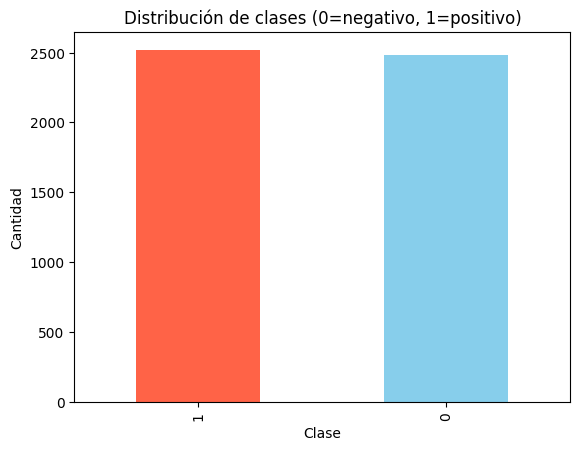

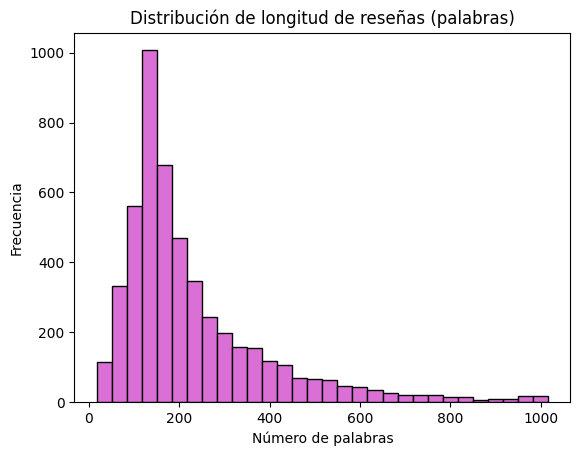

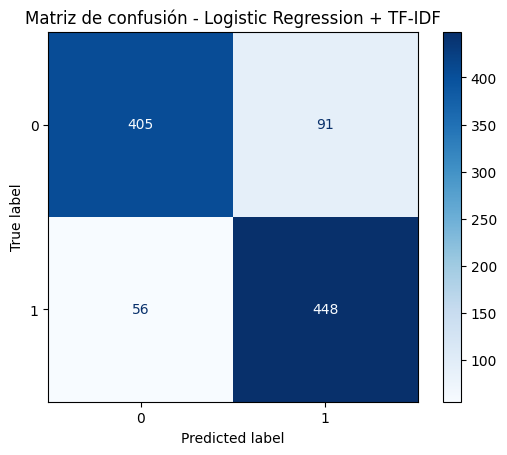

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

# 1. Distribución de clases
df[label_col].value_counts().plot(kind="bar", color=["tomato","skyblue"])
plt.title("Distribución de clases (0=negativo, 1=positivo)")
plt.xlabel("Clase")
plt.ylabel("Cantidad")
plt.show()

# 2. Histograma de longitud de reseñas
df["len_words"] = df["clean_text"].apply(lambda x: len(x.split()))
plt.hist(df["len_words"], bins=30, color="orchid", edgecolor="black")
plt.title("Distribución de longitud de reseñas (palabras)")
plt.xlabel("Número de palabras")
plt.ylabel("Frecuencia")
plt.show()

# 3. Matriz de confusión del mejor modelo (Logistic Regression + TF-IDF)
best_model = LogisticRegression(max_iter=1500, solver="liblinear")
best_model.fit(Xtr_tfidf, y_train)
y_pred = best_model.predict(Xte_tfidf)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap="Blues")
plt.title("Matriz de confusión - Logistic Regression + TF-IDF")
plt.show()
